# SIR model for COVID-19 reproducing the paper from Ma, 2022

In [1]:
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
%matplotlib widget
%config InlineBackend.figure_format='retina'

### Classic SIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} \tag{1}\\ \frac{{dI\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \lambda I\left(t \right) \tag{2}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda I\left(t \right) \tag{3} \end{align*}

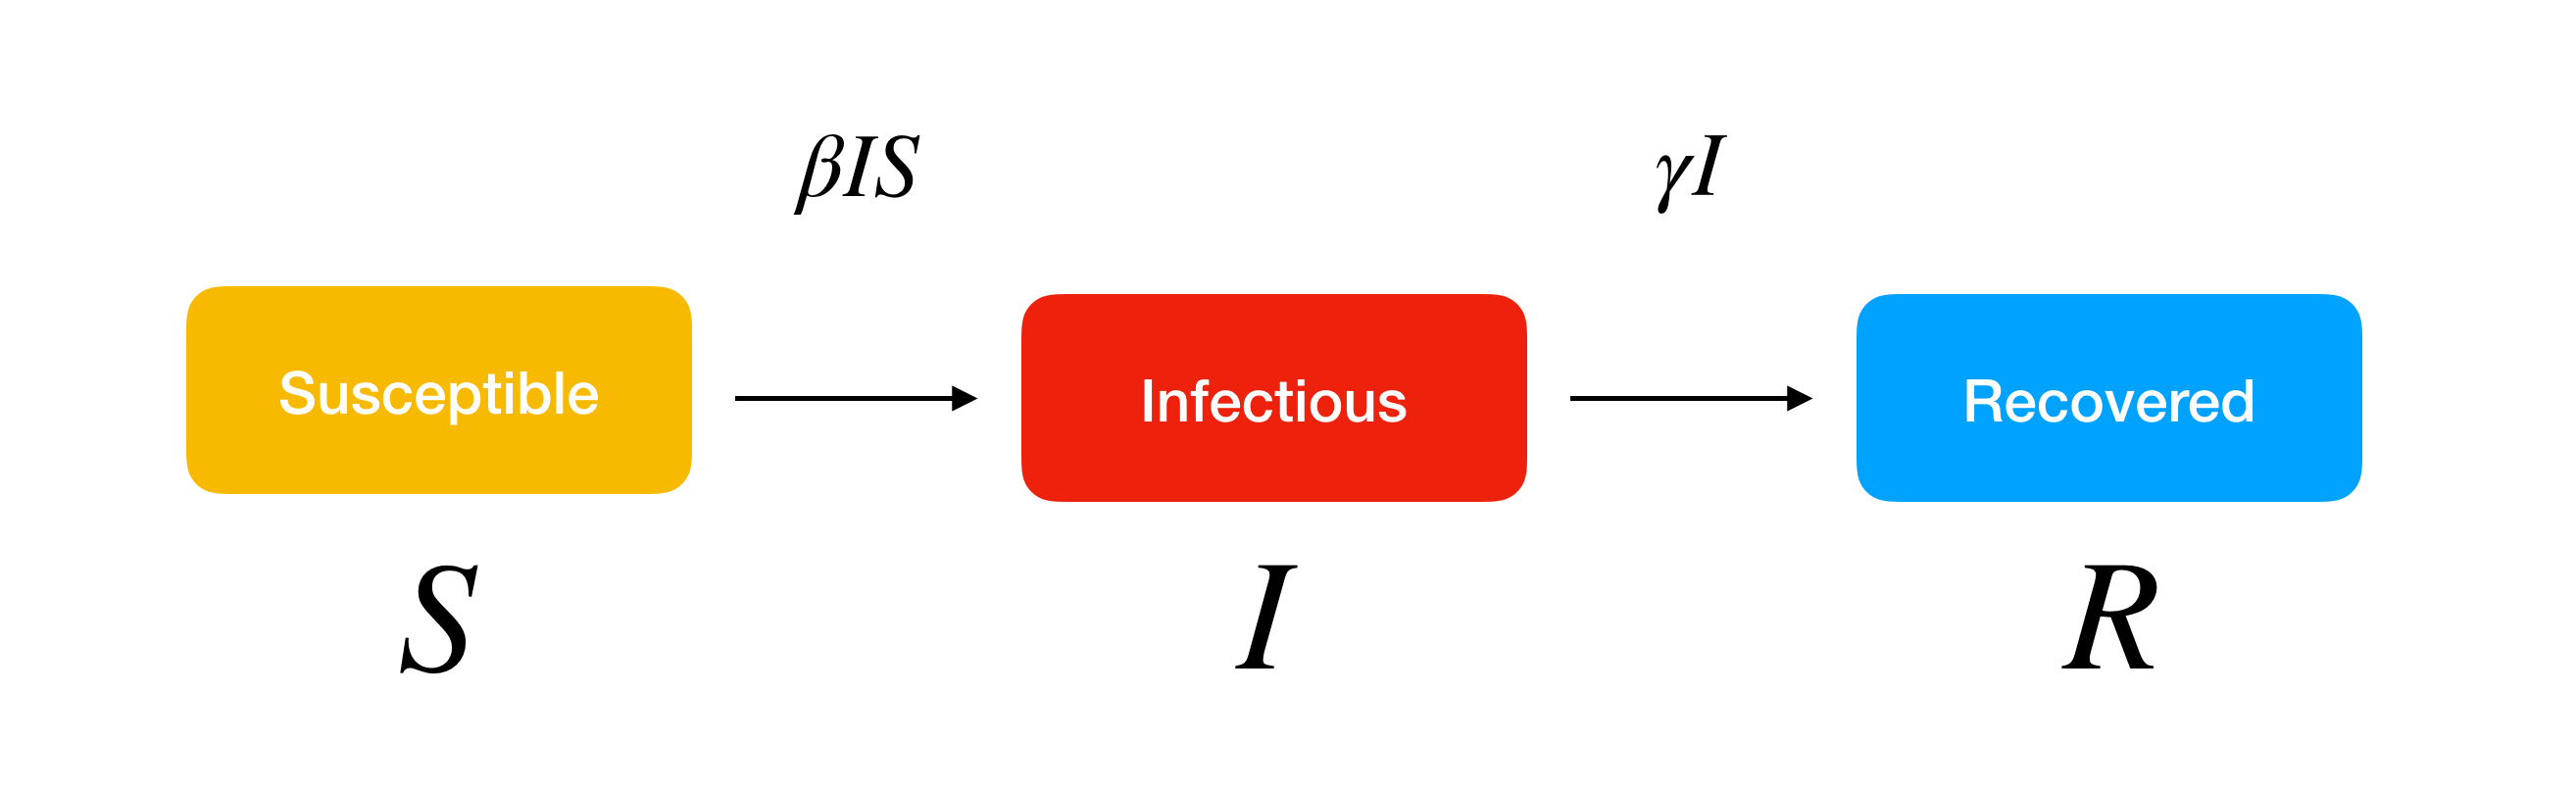

### Extended SEIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} &= - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \alpha S\left(t \right) \tag{4}\\ \frac{{dE\left(t \right)}}{{dt}} &= \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \gamma E\left(t \right) \tag{5}\\ \frac{{dI\left(t \right)}}{{dt}} &= \gamma E\left(t \right) - \delta I\left(t \right) \tag{6}\\ \frac{{dQ\left(t \right)}}{{dt}} &= \delta I\left(t \right) - \lambda Q\left(t \right) - \kappa Q\left(t \right) \tag{7}\\ \frac{{dR\left(t \right)}}{{dt}} &= \lambda Q\left(t \right) \tag{8}\\ \frac{{dD\left(t \right)}}{{dt}} &= \kappa Q\left(t \right) \tag{9}\\ \frac{{dP\left(t \right)}}{{dt}} &= \alpha S\left(t \right) \tag{10} \end{align*}

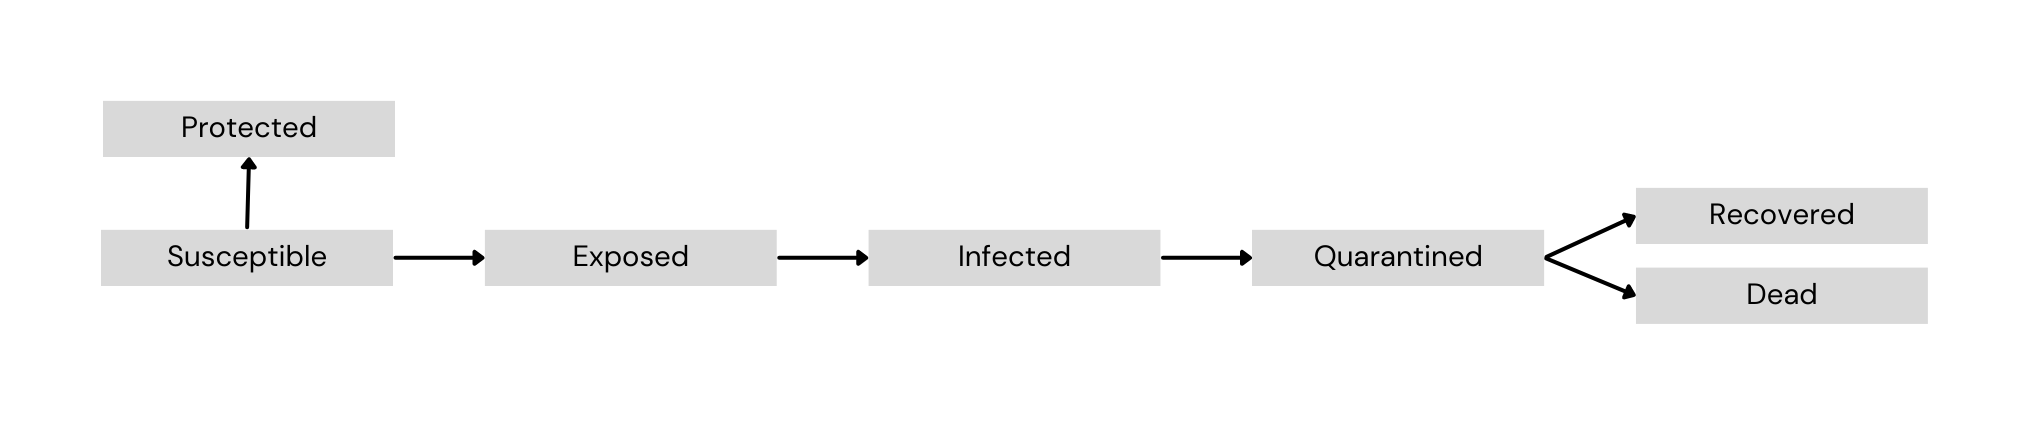

### States of the SEIR model

- $S$: susceptible people
- $E$: exposed people
- $I$: infected people not quarantined
- $Q$: infected people quarantined
- $R$: recovered people
- $D$: dead people
- $P$: protected people
- $R0$: basic reproduction number

#### Basic reproduction number R0
The basic reproduction number is included in the states of the model and is defined as
\begin{equation*} R0\ = \ \left({1 + \frac{{\ln (I(t)/t)}}{\gamma }} \right)\left({1 + \frac{{\ln (I(t)/t)}}{\lambda }} \right) \tag{11} \end{equation*}
where $I(t)$ is the number of infected populations by time $t$.

### Parameters of the SEIR model
- $N$: total number of people
- $\alpha$: protection rate
- $\beta$: infectious rate
- $\gamma^{-1}$: average incubation time
- $\delta^{-1}$: average quarantine time
- $\lambda$: cure rate
- $\kappa$: mortality rate

The `local_SEIR.py` file contains two functions, one is `solveSEIR` which is intended for using in a notebook and experiment with different inputs and outputs manually, the other is `solveSEIR_UQpy` which is intended for `UQpy` as in only returns the infected number as output.

In [3]:
from local_SEIR import solveSEIR

Set initial parameters with values from the paper.

In [4]:
alpha = 0.0183  # protection rate
beta = 0.7      # infectious rate
gamma_inv = 5   # average incubation time
delta_inv = 7   # average quarantine time
lam = 0.1       # cure rate
kappa = 0.001   # mortality rate


Call the `solveSEIR` function to produce the solution.

In [5]:
sol = solveSEIR(
    input_parameters=[alpha, beta, gamma_inv, delta_inv, lam, kappa])

Plot the results across time, and specify starting and ending day as in the paper.

In [6]:
t = np.linspace(0, 180, 10000)

start_day = 5
end_day = 180
timespan = (t >= start_day) & (t <= end_day)

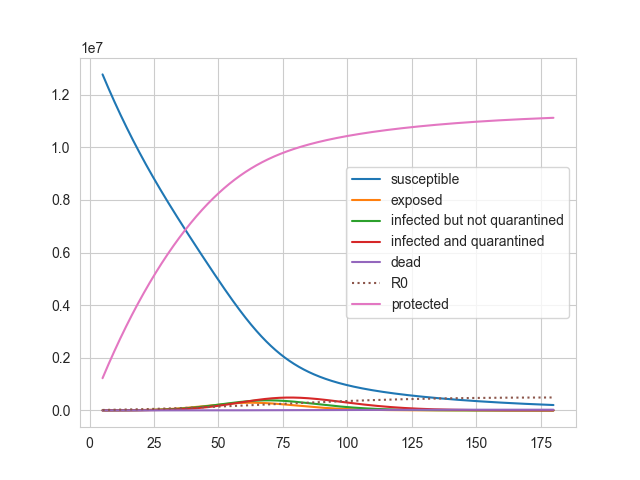

In [7]:
fig, ax = plt.subplots()
ax.plot(t[timespan], sol[0, timespan], label="susceptible")
ax.plot(t[timespan], sol[1, timespan], label="exposed")
ax.plot(t[timespan], sol[2, timespan], label="infected but not quarantined")
ax.plot(t[timespan], sol[3, timespan], label="infected and quarantined")
#ax.plot(t[timespan], sol[4, timespan], label="recovered")
ax.plot(t[timespan], sol[5, timespan], label="dead")
ax.plot(t[timespan], sol[7, timespan], label="R0", linestyle='dotted')
ax.plot(t[timespan], sol[6, timespan], label="protected")
#ax.plot(t[timespan], sol[8, timespan], label="cumulative cases")

ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


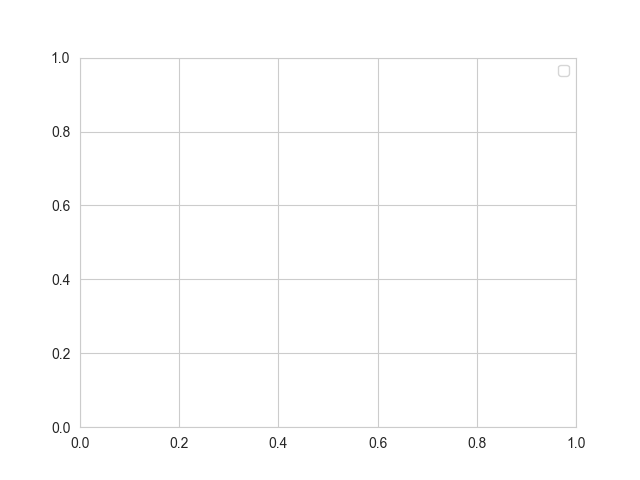

In [9]:
fig, ax = plt.subplots()
#ax.plot(t[timespan], sol[8, timespan], label="cumulative cases")

ax.legend()
plt.show()

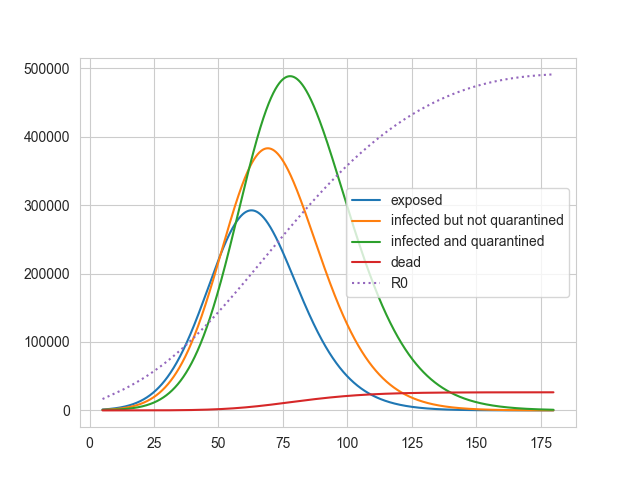

In [8]:
#Visualizing without recovered, susceptible and protected
fig, ax = plt.subplots()
#ax.plot(t[timespan], sol[0, timespan], label="susceptible")
ax.plot(t[timespan], sol[1, timespan], label="exposed")
ax.plot(t[timespan], sol[2, timespan], label="infected but not quarantined")
ax.plot(t[timespan], sol[3, timespan], label="infected and quarantined")
#ax.plot(t[timespan], sol[4, timespan], label="recovered")
ax.plot(t[timespan], sol[5, timespan], label="dead")
#ax.plot(t[timespan], sol[6, timespan], label="protected")
ax.plot(t[timespan], sol[7, timespan], label="R0", linestyle='dotted')

ax.legend()
plt.show()

### Sensitivity Analysis

Import relevant modules and classes from `UQpy`.

In [9]:
from UQpy.run_model.RunModel import RunModel
from UQpy.run_model.model_execution.PythonModel import PythonModel
from UQpy.distributions import Uniform
from UQpy.distributions.collection.JointIndependent import JointIndependent
from UQpy.sensitivity.SobolSensitivity import SobolSensitivity
from UQpy.sensitivity.PostProcess import *

Create `PythonModel` object.

In [10]:
model = PythonModel(
    model_script="local_SEIR.py", # this file must be in the same folder
    model_object_name="solveSEIR_UQpy", # this is the name of the main function called in local_SEIR.py
    var_names=["alpha", # same order used when unpacking the parameters in solveSEIR
               "beta",
               "gamma_inv",
               "delta_inv",
               "lam",
               "kappa"
              ],
    delete_files=True
)

runmodel_obj = RunModel(model=model)

We set a uniform distribution as in the paper using `UQpy.distributions.Uniform`.

The `Uniform` distribution is based on `scipy` and receives `loc` and `scale`, so if
$$
U\sim U([a,b]) \qquad f_U(x;a,b) = \frac{1}{b-a}
$$
then
$$
a = loc \qquad b = loc + scale
$$
therefore
$$
loc = a \qquad scale = b - a
$$

In [29]:
A     = Uniform(0.085, (0.183 - 0.085 ))
B     = Uniform(0.7, (0.9 - 0.7))
G_inv = Uniform(5, (7 - 5 ))
D_inv = Uniform(7, (14 - 7))
L     = Uniform(0.1, (0.5 - 0.1 ))
K     = Uniform(0.001, (0.05 - 0.001 ))

dist_object = JointIndependent([A, B, G_inv, D_inv, L, K])


Perform the sensitivity analysis and measure the time taken by the cell to execute it.

In [12]:
%%time
SA = SobolSensitivity(runmodel_obj, dist_object)
SA.run(n_samples=2000, estimate_second_order=True)

CPU times: user 2min 32s, sys: 14.9 s, total: 2min 47s
Wall time: 2min 58s


Investigate the shape of the resulting quantities.

In [13]:
np.shape(SA.first_order_indices)

(6, 10000)

In [14]:
np.shape(SA.second_order_indices)

(15, 10000)

Plot the first order indexes in 3D.

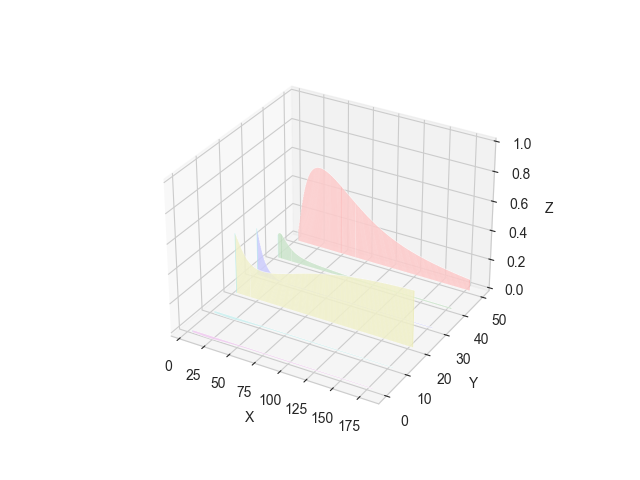

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

c = ['r', 'g', 'b', 'y', 'c', 'm']
z = [50, 40, 30, 20, 10, 0]

for i in range(np.shape(SA.first_order_indices.T[1:])[1]):
    xs = t[timespan]
    ys = SA.first_order_indices[i, timespan]
    
    # subsample every 100
    xs = xs[::30]
    ys = ys[::30]

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c[i]] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys, zs=z[i], zdir='y', color=cs, alpha=0.3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(0,1)

plt.show()

### Plotting first order Sobol indices in time

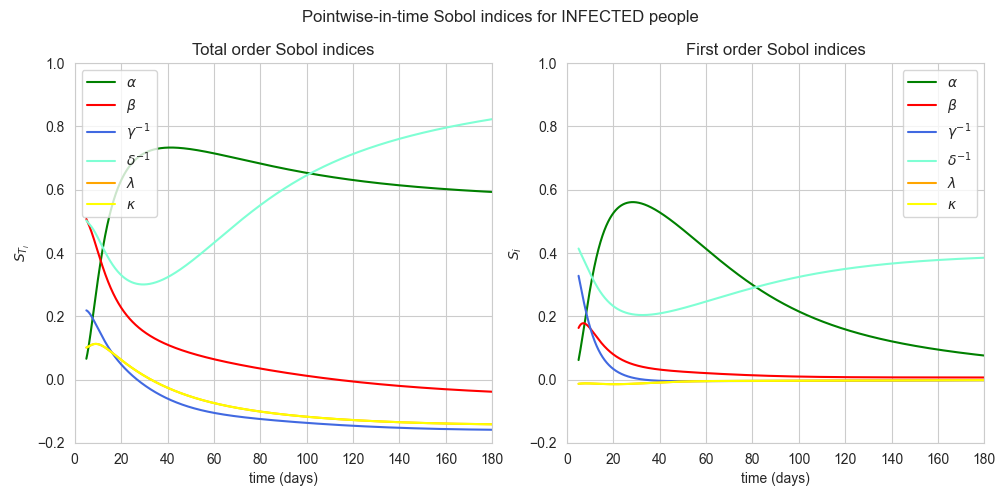

In [18]:
#fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Total order
ax[0].plot(t[timespan], SA.total_order_indices[0, timespan], "g",label=r"$\alpha$")
ax[0].plot(t[timespan], SA.total_order_indices[1, timespan], "r" ,label=r"$\beta$")
ax[0].plot(t[timespan], SA.total_order_indices[2, timespan], label=r"$\gamma^{-1}$", color="royalblue")
ax[0].plot(t[timespan], SA.total_order_indices[3, timespan], label=r"$\delta^{-1}$", color="aquamarine")
ax[0].plot(t[timespan], SA.total_order_indices[4, timespan], label=r"$\lambda$", color="orange")
ax[0].plot(t[timespan], SA.total_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

ax[0].set_title("Total order Sobol indices")
ax[0].set_xlabel("time (days)")
ax[0].set_ylabel(r"$S_{T_i}$")
ax[0].set_xbound(0, t[-1])
ax[0].set_ybound(-0.2, 1)
ax[0].legend()

#fiirst order
ax[1].plot(t[timespan], SA.first_order_indices[0, timespan], "g",label=r"$\alpha$")
ax[1].plot(t[timespan], SA.first_order_indices[1, timespan], "r" ,label=r"$\beta$")
ax[1].plot(t[timespan], SA.first_order_indices[2, timespan], label=r"$\gamma^{-1}$", color="royalblue")
ax[1].plot(t[timespan], SA.first_order_indices[3, timespan], label=r"$\delta^{-1}$", color="aquamarine")
ax[1].plot(t[timespan], SA.first_order_indices[4, timespan], label=r"$\lambda$", color="orange")
ax[1].plot(t[timespan], SA.first_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

ax[1].set_title("First order Sobol indices")
ax[1].set_xlabel("time (days)")
ax[1].set_ylabel(r"$S_i$")
ax[1].set_xbound(0, t[-1])
ax[1].set_ybound(-0.2, 1)
ax[1].legend()

fig.suptitle("Pointwise-in-time Sobol indices for INFECTED people")
fig.tight_layout(pad=1.0)

plt.show()

#### General comments

- The time dynamics of the first-order Sobol index for each parameter fully reproduces the results from the paper
- The parameter alpha, modelling the protection rate, is the most highli influential for the number of infected cases
- Also the average quarantine time seems to have a very important role 

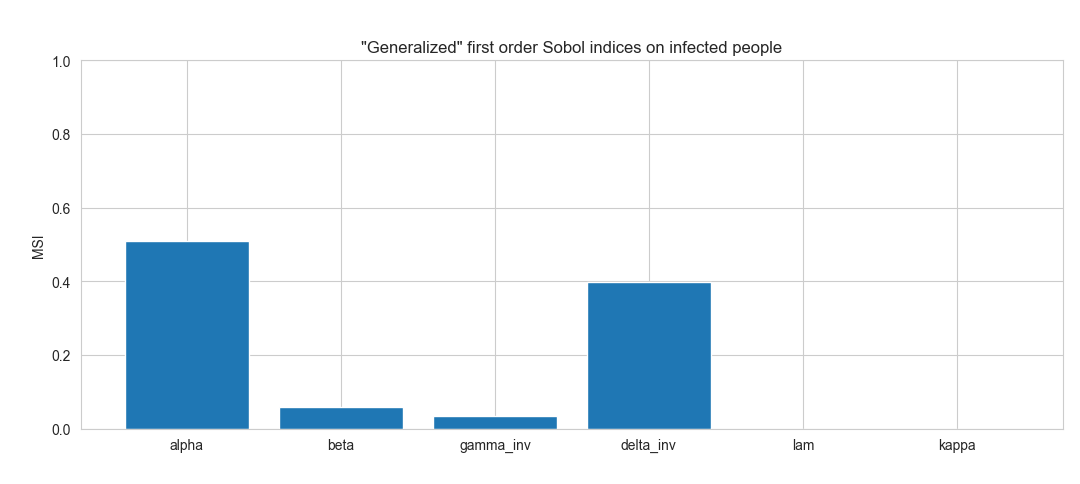

In [20]:
from scipy.integrate import cumulative_trapezoid

sobol_first = SA.first_order_indices[:, timespan]
# Set to zero negative elements
sobol_first[sobol_first < 0] = 0

x = t[timespan]

num_inputs = np.shape(SA.first_order_indices)[0]

# Initialize output vector
first_s_int = np.zeros(num_inputs)

# Compute strange integral
for i in range(num_inputs):
    y = sobol_first[i, :]
    result = cumulative_trapezoid(y, x)
    first_s_int[i] = sum(result)

# Normalize with the sum of all
first_s_int = first_s_int / np.sum(first_s_int)

var_names=["alpha",
           "beta",
           "gamma_inv",
           "delta_inv",
           "lam",
           "kappa"]

plt.clf()
plt.bar(var_names, first_s_int)

plt.ylim(0,1)
plt.ylabel('MSI')
plt.title('"Generalized" first order Sobol indices on infected people')
plt.show()

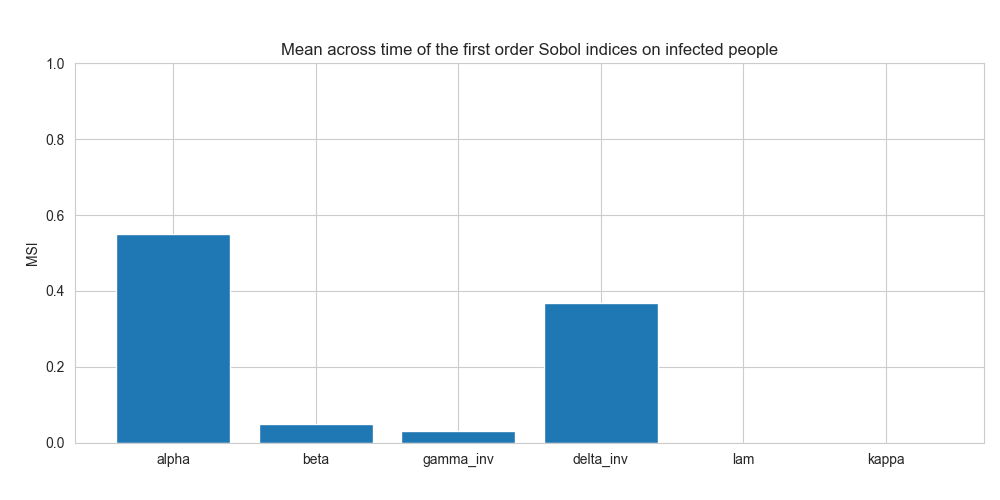

In [83]:
#Approach 2: mean over time
first_order_sobol_mean=np.array(np.zeros(6))
total_sobol_mean=np.array(np.zeros(6))

#Starting from day 5 as they did
for i in range(6):
    first_order_sobol_mean[i]=np.mean(SA.first_order_indices[i, timespan])
    total_sobol_mean[i]=np.mean(SA.total_order_indices[i, timespan])
    

var_names=["alpha",
           "beta",
           "gamma_inv",
           "delta_inv",
           "lam",
           "kappa"]

plt.clf()
plt.bar(var_names, first_s_int)

plt.ylim(0,1)
plt.ylabel('MSI')
plt.title('Mean across time of the first order Sobol indices on infected people')
plt.show()

#### Factor prioritization from first order sobol indices

Independently of the method chosen, the ranking of the factors according to the first-order Sobol index is the following

1. $\alpha$
2. $\delta^{-1}$
3. $\beta$
4. $\gamma^{-1}$
5. $\lambda$ and $\kappa$

### Plotting how the number of infected cases vary changing alpha

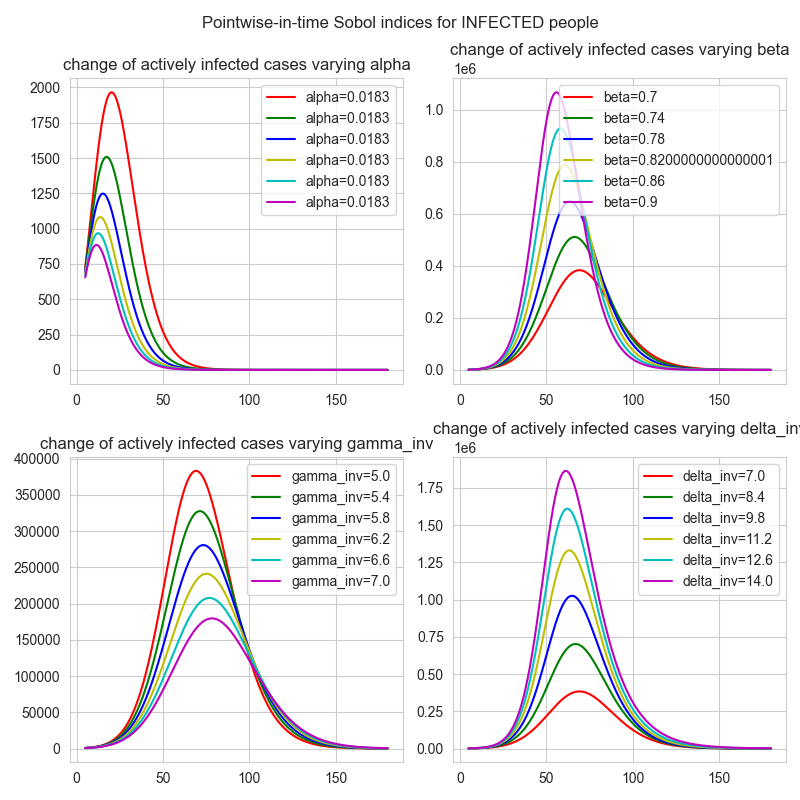

In [35]:
#fig, ax = plt.subplots()

n_values=6

alpha_range=np.linspace(0.0916, 0.185, n_values)
beta_range=np.linspace(0.7, 0.9, n_values)
gamma_inv_range=np.linspace(5, 7, n_values)
delta_inv_range=np.linspace(7, 14, n_values)


c = ['r', 'g', 'b', 'y', 'c', 'm']

I_max_alpha=np.array(np.zeros(n_values))
I_max_beta=np.array(np.zeros(n_values))
I_max_gamma_inv=np.array(np.zeros(n_values))
I_max_delta_inv=np.array(np.zeros(n_values))


fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Total order
for i in range(len(alpha_range)):
    
    alpha_t=alpha_range[i]
    sol = solveSEIR(input_parameters=[alpha_t, beta, gamma_inv, delta_inv, lam, kappa])
    I_max_alpha[i]=np.max(sol[2,:])
    ax[0,0].plot(t[timespan], sol[2, timespan],label=f"alpha={alpha}", color=c[i])


    beta_t=beta_range[i]
    sol = solveSEIR(input_parameters=[alpha, beta_t, gamma_inv, delta_inv, lam, kappa])
    ax[0,1].plot(t[timespan], sol[2, timespan],label=f"beta={beta_t}", color=c[i])
    I_max_beta=np.max(sol[2,:])

    gamma_inv_t=gamma_inv_range[i]
    sol = solveSEIR(input_parameters=[alpha, beta, gamma_inv_t, delta_inv, lam, kappa])
    ax[1,0].plot(t[timespan], sol[2, timespan],label=f"gamma_inv={gamma_inv_t}", color=c[i])
    I_max_gamma_inv=np.max(sol[2,:])
    
    delta_inv_t=delta_inv_range[i]
    sol = solveSEIR(input_parameters=[alpha, beta, gamma_inv, delta_inv_t, lam, kappa])
    ax[1,1].plot(t[timespan], sol[2, timespan],label=f"delta_inv={delta_inv_t}", color=c[i])
    I_max_delta_inv=np.max(sol[2,:])

        
ax[0,0].set_title("change of actively infected cases varying alpha")
ax[0,0].legend()

ax[0,1].set_title("change of actively infected cases varying beta")
ax[0,1].legend()

ax[1,0].set_title("change of actively infected cases varying gamma_inv")
ax[1,0].legend()


ax[1,1].set_title("change of actively infected cases varying delta_inv")
ax[1,1].legend()


fig.suptitle("Pointwise-in-time Sobol indices for INFECTED people")
fig.tight_layout(pad=1.0)

plt.show()    

 


In [65]:
print(I_max)

[1965.43581433 1508.64854967 1248.38264224 1082.42018333  968.14027241
  884.96517187]


# DUBBIO ENORME: NOI ABBIAMO DUE TIPI DI INFETTATI, FINO A ORA ABBIAMO USATO "I" (NON QUARANTENATI)

### Assessing higher order interactions -ATTENZIONE VANNO RISISTEMATE PERCHE' C'è ANCHE R0


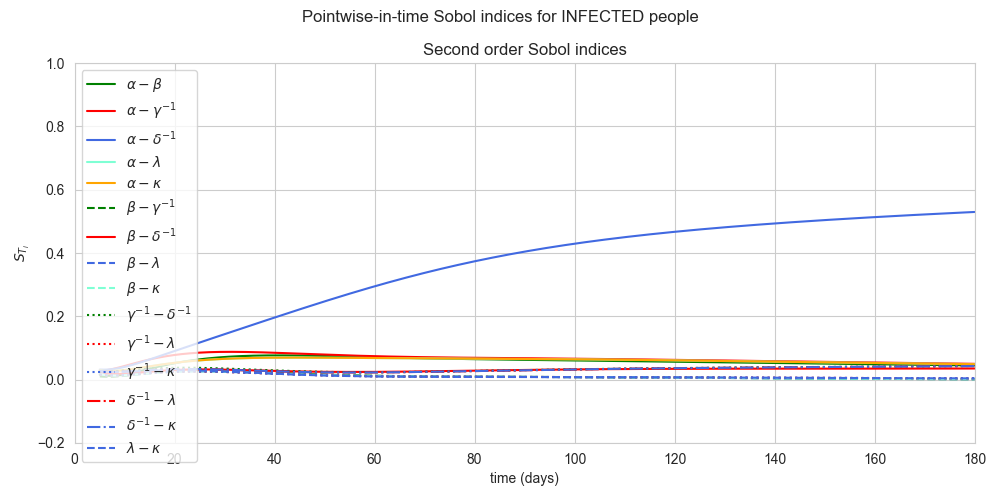

In [24]:
#fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig, ax = plt.subplots(figsize=(10,5))

# Alpha
ax.plot(t[timespan], SA.second_order_indices[0, timespan], "g",label=r"$\alpha-\beta$")
ax.plot(t[timespan], SA.second_order_indices[1, timespan], "r" ,label=r"$\alpha-\gamma^{-1}$")
ax.plot(t[timespan], SA.second_order_indices[2, timespan], label=r"$\alpha-\delta^{-1}$", color="royalblue")
ax.plot(t[timespan], SA.second_order_indices[3, timespan], label=r"$\alpha-\lambda$", color="aquamarine")
ax.plot(t[timespan], SA.second_order_indices[4, timespan], label=r"$\alpha-\kappa$", color="orange")

ax.plot(t[timespan], SA.second_order_indices[5, timespan], "g",label=r"$\beta-\gamma^{-1}$", linestyle='dashed')
ax.plot(t[timespan], SA.second_order_indices[6, timespan], "r" ,label=r"$\beta-\delta^{-1}$")
ax.plot(t[timespan], SA.second_order_indices[7, timespan], label=r"$\beta-\lambda$", color="royalblue", linestyle='dashed')
ax.plot(t[timespan], SA.second_order_indices[8, timespan], label=r"$\beta-\kappa$", color="aquamarine", linestyle='dashed')

ax.plot(t[timespan], SA.second_order_indices[9, timespan], "g",label=r"$\gamma^{-1}-\delta^{-1}$", linestyle='dotted')
ax.plot(t[timespan], SA.second_order_indices[10, timespan], "r" ,label=r"$\gamma^{-1}-\lambda$", linestyle='dotted')
ax.plot(t[timespan], SA.second_order_indices[11, timespan], label=r"$\gamma^{-1}-\kappa$", color="royalblue", linestyle='dotted')

ax.plot(t[timespan], SA.second_order_indices[12, timespan], "r" ,label=r"$\delta^{-1}-\lambda$", linestyle='dashdot')
ax.plot(t[timespan], SA.second_order_indices[13, timespan], label=r"$\delta^{-1}-\kappa$", color="royalblue", linestyle='dashdot')

ax.plot(t[timespan], SA.second_order_indices[14, timespan], label=r"$\lambda-\kappa$", color="royalblue", linestyle='dashed')
#, linestyle='dashed'

#ax[0].plot(t[timespan], SA.second_order_indices[5, timespan], label=r"$\kappa$", color="yellow")

ax.set_title("Second order Sobol indices")
ax.set_xlabel("time (days)")
ax.set_ylabel(r"$S_{T_i}$")
ax.set_xbound(0, t[-1])
ax.set_ybound(-0.2, 1)
ax.legend()

fig.suptitle("Pointwise-in-time Sobol indices for INFECTED people")
fig.tight_layout(pad=1.0)

plt.show()

In [44]:
#TODO ADD BARPLOT WITH THE MEAN

#### Comments

- The most influential interaction is between the protection rate $\alpha$ and the average quarantine time $\delta^{-1}$, which steadily increases fro day 30 and remains high until day 180
- The second most important interaction (although small) is between $\alpha$ and $\beta$, which represents the infection rate

# NEXT STEPS

Today:
- Reproducing the results on R0
- Reproducing results on another parameter (the cumulative infected cases like in the paper, for example)

Tomorrow:
- Improve the quality of the comments and the critical analysis of the results, even in comparison with the paper
- Performing UQ on initial variables like in the paper (for example I0)
- Anticipate possible questions (conceptual and practical)


Toyota:
- Ideas for further exploring the potential of the library? 
    - Changing method to compute the other results
    - Use of the PCE to compute sobol indexes on the surrogate model? maybe not worth it
    - Morris method! for elementary effects, could be nice!
    - Another idea: we could take one moment in time (for example at the peak of infection) and compute sobol indexes at that time, and compare it with other indexes using functions from the library